C:\Users\aksha\AppData\Local\Temp\ipykernel_7028\1552120082.py:16: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f"{col}_ret"] = df[col].pct_change()
C:\Users\aksha\AppData\Local\Temp\ipykernel_7028\1552120082.py:16: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f"{col}_ret"] = df[col].pct_change()



📊 Top Feature Correlations with NIFTY_50 Returns:

                 Feature  Correlation
               SP500_ret     0.334717
          SP500_ret_lag1     0.231665
           SP500_ret_ma3     0.181283
             SP500_trend     0.179296
    SP500_ret_momentum20     0.163081
     SP500_ret_momentum3     0.161461
     SP500_ret_momentum5     0.160220
          SP500_ret_ma10     0.131831
    SP500_ret_momentum10     0.131576
           SP500_ret_ma5     0.129480
          SP500_ret_ma20     0.084448
      INDIA_VIX_ret_std3     0.062847
      INDIA_VIX_ret_std5     0.059038
          SP500_ret_lag2     0.054785
       NIFTY_50_ret_lag1     0.036194
 NIFTY_50_ret_momentum20     0.034750
  NIFTY_50_ret_momentum3     0.033744
     INDIA_VIX_ret_std10     0.033002
      NIFTY_50_ret_std20     0.023810
        USD_INR_ret_std3     0.022259
     INDIA_VIX_ret_std20     0.022222
       NIFTY_50_ret_std3     0.020455
INDIA_VIX_ret_momentum10     0.019347
       NIFTY_50_ret_ma20     0.01770

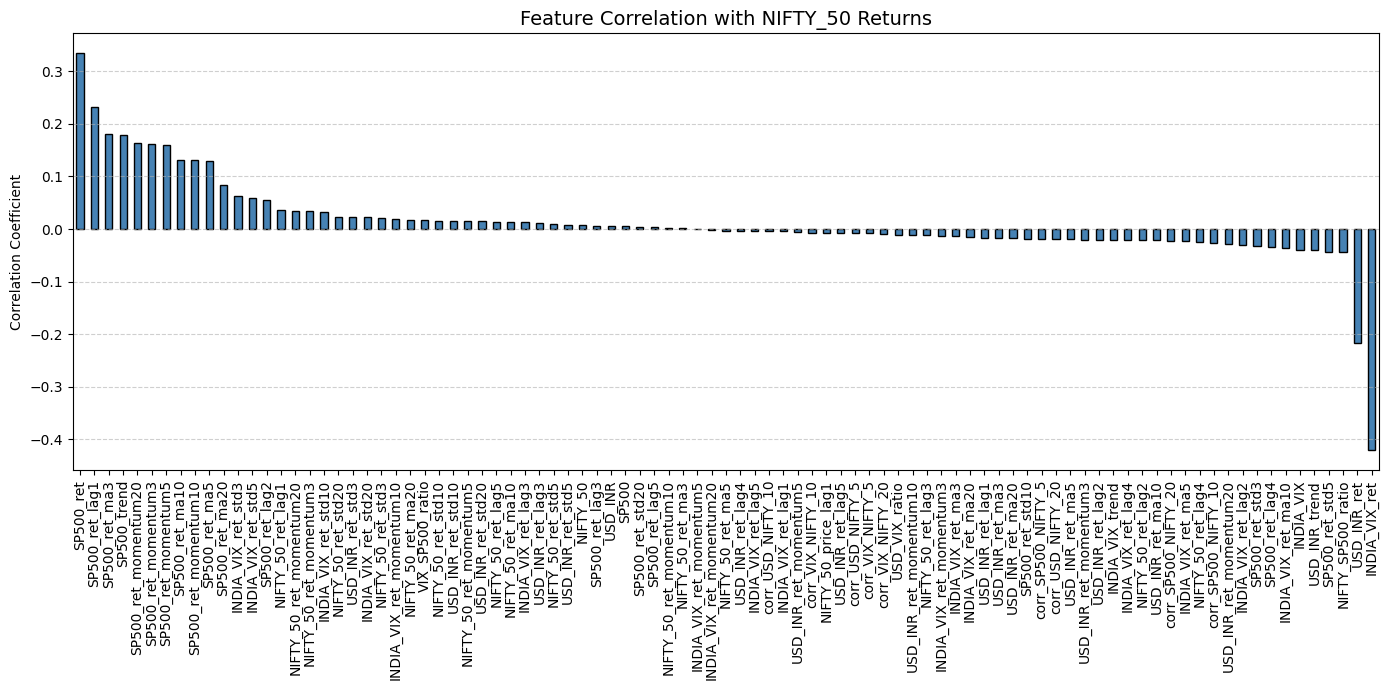


✅ Feature engineering complete and correlation plotted!
🧮 Total features created: 92


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 📂 1. Load CSV
# ============================================================
df = pd.read_csv("../data/raw/correlation_info.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# ============================================================
# ⚙️ 2. Create base return features
# ============================================================
for col in ["NIFTY_50", "SP500", "INDIA_VIX", "USD_INR"]:
    df[f"{col}_ret"] = df[col].pct_change()

# ============================================================
# 🔁 3. Lag Features (past 1–5 days)
# ============================================================
for col in ["SP500_ret", "INDIA_VIX_ret", "USD_INR_ret", "NIFTY_50_ret"]:
    for lag in range(1, 6):
        df[f"{col}_lag{lag}"] = df[col].shift(lag)

# ============================================================
# 📊 4. Rolling Mean, Std, and Momentum (look-back 3, 5, 10, 20)
# ============================================================
for col in ["SP500_ret", "INDIA_VIX_ret", "USD_INR_ret", "NIFTY_50_ret"]:
    for win in [3, 5, 10, 20]:
        df[f"{col}_ma{win}"] = df[col].shift(1).rolling(window=win).mean()
        df[f"{col}_std{win}"] = df[col].shift(1).rolling(window=win).std()
        df[f"{col}_momentum{win}"] = (
            df[col]
            .shift(1)
            .rolling(window=win)
            .apply(lambda x: x.iloc[-1] - x.iloc[0])
        )

# ============================================================
# 🔗 5. Cross-asset correlation features (SP500 ↔ NIFTY, VIX ↔ NIFTY)
# ============================================================
windows = [5, 10, 20]
for win in windows:
    df[f"corr_SP500_NIFTY_{win}"] = (
        df["SP500_ret"].shift(1).rolling(window=win)
        .corr(df["NIFTY_50_ret"].shift(1))
    )
    df[f"corr_VIX_NIFTY_{win}"] = (
        df["INDIA_VIX_ret"].shift(1).rolling(window=win)
        .corr(df["NIFTY_50_ret"].shift(1))
    )
    df[f"corr_USD_NIFTY_{win}"] = (
        df["USD_INR_ret"].shift(1).rolling(window=win)
        .corr(df["NIFTY_50_ret"].shift(1))
    )

# ============================================================
# 🧠 6. Volatility Ratios & Price Relationships
# ============================================================
df["VIX_SP500_ratio"] = df["INDIA_VIX"].shift(1) / df["SP500"].shift(1)
df["USD_VIX_ratio"] = df["USD_INR"].shift(1) / df["INDIA_VIX"].shift(1)
df["NIFTY_SP500_ratio"] = df["NIFTY_50"].shift(1) / df["SP500"].shift(1)

# ============================================================
# 🧮 7. Trend direction features (up/down from yesterday)
# ============================================================
for col in ["SP500", "INDIA_VIX", "USD_INR"]:
    df[f"{col}_trend"] = np.where(df[col].shift(1) > df[col].shift(2), 1, -1)

# ============================================================
# 💰 7.5 Add NIFTY_50 price lag feature (yesterday's price)
# ============================================================
df["NIFTY_50_price_lag1"] = df["NIFTY_50"].shift(1)

# ============================================================
# 🚫 8. Drop NaN values (from rolling/lags)
# ============================================================
df.dropna(inplace=True)

# ============================================================
# 📈 9. Correlation Analysis (with NIFTY_50_ret)
# ============================================================
corr = df.corr()
corr_target = corr["NIFTY_50_ret"].sort_values(ascending=False)

# 🔍 Print correlation table
print("\n📊 Top Feature Correlations with NIFTY_50 Returns:\n")
corr_table = corr_target.drop("NIFTY_50_ret").reset_index()
corr_table.columns = ["Feature", "Correlation"]
print(corr_table.to_string(index=False))

# ============================================================
# 🎨 10. Plot correlation bar chart
# ============================================================
plt.figure(figsize=(14, 7))
corr_target.drop("NIFTY_50_ret").plot(kind="bar", color="steelblue", edgecolor="black")
plt.title("Feature Correlation with NIFTY_50 Returns", fontsize=14)
plt.ylabel("Correlation Coefficient")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# ============================================================
# 💾 11. Save processed data
# ============================================================
df.to_csv("../data/processed/featured_dataset.csv")

print("\n✅ Feature engineering complete and correlation plotted!")
print(f"🧮 Total features created: {len(df.columns)}")


In [10]:
import pandas as pd

def save_selected_features():
    input_path = "../data/processed/featured_dataset.csv"
    output_path = "../data/processed/best_features.csv"

    selected_features = [
        'SP500_ret_lag1',
        'SP500_ret_ma3',
        'SP500_trend',
        'SP500_ret_momentum3',
        'SP500_ret_momentum5',
        'SP500_ret_momentum10',
        'SP500_ret_momentum20',
        'USD_INR_ret_lag1',
        'INDIA_VIX_ret_lag1',
        'NIFTY_50_ret_lag1',
        'INDIA_VIX_ret_ma3',
        'INDIA_VIX_ret_ma5',
        'USD_INR_ret_ma3',
        'USD_INR_ret_ma5',
        'NIFTY_50_ret'
    ]

    df = pd.read_csv(input_path)
    filtered_df = df[selected_features]
    filtered_df.to_csv(output_path, index=False)

    print("✅ best_features.csv saved")

if __name__ == "__main__":
    save_selected_features()


✅ best_features.csv saved


In [11]:
import pandas as pd

def save_selected_features():
    input_path = "../data/processed/featured_dataset.csv"
    output_path = "../data/processed/backtest_ready.csv"

    selected_features = [
        'Date',
        'NIFTY_50',
        'NIFTY_50_ret',
        'SP500_ret_lag1',
        'SP500_ret_ma3',
        'SP500_trend',
        'SP500_ret_momentum3',
        'SP500_ret_momentum5',
        'SP500_ret_momentum10',
        'SP500_ret_momentum20',
        'USD_INR_ret_lag1',
        'INDIA_VIX_ret_lag1',
        'NIFTY_50_ret_lag1',
        'INDIA_VIX_ret_ma3',
        'INDIA_VIX_ret_ma5',
        'USD_INR_ret_ma3',
        'USD_INR_ret_ma5'
    ]

    df = pd.read_csv(input_path)
    filtered_df = df[selected_features]
    filtered_df.to_csv(output_path, index=False)

    print("✅ backtest_ready.csv saved")

if __name__ == "__main__":
    save_selected_features()


✅ backtest_ready.csv saved


In [12]:
import pandas as pd

def save_selected_features():
    input_path = "../data/processed/featured_dataset.csv"
    output_path = "../data/processed/web_feed.csv"

    # ⚠️ MUST MATCH TRAINING FEATURES EXACTLY
    selected_features = [
        'SP500_ret_lag1',
        'SP500_ret_ma3',
        'SP500_trend',
        'SP500_ret_momentum3',
        'SP500_ret_momentum5',
        'SP500_ret_momentum10',
        'SP500_ret_momentum20',
        'USD_INR_ret_lag1',
        'INDIA_VIX_ret_lag1',
        'NIFTY_50_ret_lag1',
        'INDIA_VIX_ret_ma3',
        'INDIA_VIX_ret_ma5',
        'USD_INR_ret_ma3',
        'USD_INR_ret_ma5'
    ]

    df = pd.read_csv(input_path)

    # Drop rows where features are not available
    df = df.dropna(subset=selected_features)

    # Save latest inference-ready features
    df[selected_features].to_csv(output_path, index=False)

    print("✅ web_feed.csv saved (feature-aligned with training)")

if __name__ == "__main__":
    save_selected_features()


✅ web_feed.csv saved (feature-aligned with training)
